<a href="https://colab.research.google.com/github/Drit92/DVD_Project/blob/main/DVD_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Loan Repayment Behavior Analysis**

# **1. Setup and Data Loading**





In [ ]:
# @title
# Downloading and Extracting Zip
import os
# Install gdown to download files from Google Drive
!pip install gdown -qq
# Define the Google Drive file ID from the provided link
file_id = '1FSSkKQOJtvOpP1I1qyr4x6SYQg-kBnVw'
output_filename = 'dataset.zip'
# Download the file using gdown
!gdown --id {file_id} -O {output_filename}
print(f"Downloaded '{output_filename}'")
import zipfile
# Define the name of the zip file to extract
zip_file_name = 'dataset.zip'

# Define the directory where the contents will be extracted
extraction_path = '.' # Extract to the current directory

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Extracted '{zip_file_name}' to '{extraction_path}'")
print("Contents of the extracted directory:")
!ls -F {extraction_path}

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1FSSkKQOJtvOpP1I1qyr4x6SYQg-kBnVw
From (redirected): https://drive.google.com/uc?id=1FSSkKQOJtvOpP1I1qyr4x6SYQg-kBnVw&confirm=t&uuid=5f13e088-1f63-41e0-84fe-b9fa04a4ac17
To: /content/dataset.zip
100% 114M/114M [00:01<00:00, 61.3MB/s] 
Downloaded 'dataset.zip'
Extracted 'dataset.zip' to '.'
Contents of the extracted directory:
dataset.zip  file_zip/	sample_data/


In [ ]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
sns.set_style('whitegrid')

# 2. Load the datasets
try:
    app_data = pd.read_csv('/content/file_zip/application_data.csv')
    prev_data = pd.read_csv('/content/file_zip/previous_application.csv')
    # columns_desc = pd.read_csv('/content/file_zip/columns_description.xlsx') # For reference

    print("Data loaded successfully!")
    print(f"Application Data Shape: {app_data.shape}")
    print(f"Previous Application Data Shape: {prev_data.shape}")
except FileNotFoundError:
    print("Ensure the CSV files are uploaded to your Colab environment or linked to Drive.")

Data loaded successfully!
Application Data Shape: (307511, 122)
Previous Application Data Shape: (1670214, 37)


**outcomes**
1. Data Structure and Class Imbalance

*   Application Data Shape: (7760 rows, 122 columns)
*   Previous Application Data Shape: (16973 rows, 37 columns).





# **2. Initial Data Inspection and Definition**

# 2.1 Target Variable Analysis : The core problem
 checking  the `TARGET` variable first to understand the scale of the business problem and the data's class distribution.


 A. Target Variable Distribution 
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


/tmp/ipython-input-1259368197.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette=['skyblue', 'salmon'])


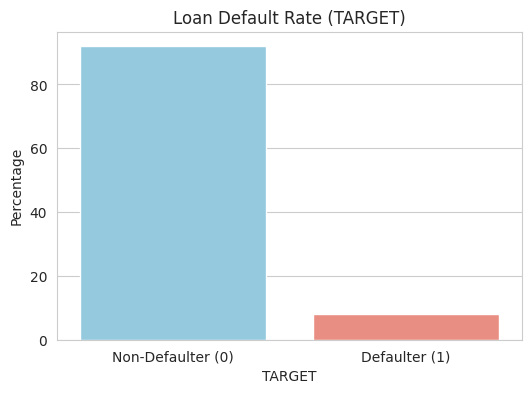


 B. Application Data Info 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [ ]:
# Check the TARGET variable (1=Defaulter, 0=Non-Defaulter)
print("\n A. Target Variable Distribution ")
target_counts = app_data['TARGET'].value_counts(normalize=True) * 100
print(target_counts)

# Visualize the class imbalance
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette=['skyblue', 'salmon'])
plt.title('Loan Default Rate (TARGET)')
plt.xticks([0, 1], ['Non-Defaulter (0)', 'Defaulter (1)'])
plt.ylabel('Percentage')
plt.show()

# Quick look at data types and the first few rows
print("\n B. Application Data Info ")
app_data.info(verbose=False)
# Note: The data dictionary helps identify which columns are numerical (e.g., AMT_CREDIT)
# and which are categorical (e.g., NAME_INCOME_TYPE).

**OUTCOME**

**Default Rate** (TARGET): 8.07
% (Target=1, Defaulter).

**Interpretation**: The data is highly imbalanced (approx. 92% non-defaulters). This is typical for credit risk data and means the models will need to be evaluated using metrics like AUC-ROC or Precision/Recall, not just standard accuracy.


2.2 **Data Summary**

In [ ]:
def summarize_dataframe(df, name):
    # Create the summary table
    summary = []
    for col in df.columns:
        dtype = df[col].dtype
        nunique = df[col].nunique()
        missing_count = df[col].isnull().sum()
        missing_pct = missing_count / len(df) * 100

        # Determine if the column is categorical or numerical
        # Heuristic: object types or numerical columns with very few unique values are treated as categorical.
        if dtype in ['object', 'category'] or nunique < 50 and dtype != 'float64':
            category = 'Categorical/Low-Cardinality'
            # Get the top 5 most frequent values for context
            top_values_list = df[col].value_counts().head(5).index.tolist()
            top_values_str = ", ".join([str(val) for val in top_values_list])
        else:
            category = 'Numerical/High-Cardinality'
            # Get key statistics for numerical fields
            try:
                stats = df[col].describe().apply(lambda x: f'{x:.2f}').to_dict()
                top_values_str = f"Mean: {stats['mean']}, Std: {stats['std']}, Min: {stats['min']}, Max: {stats['max']}"
            except:
                 top_values_str = "N/A (Non-numeric data in numerical column)"


        summary.append({
            'Column Name': col,
            'Data Type': dtype,
            'Unique Values': nunique,
            'Missing Count': missing_count,
            'Missing (%)': f"{missing_pct:.2f}%",
            'Inferred Type': category,
            'Top/Stat Values': top_values_str
        })

    summary_df = pd.DataFrame(summary)

    # --- Display Summaries ---

    print("\n--- A. Missing Value Report (Top 20 Missing Columns) ---")
    missing_report = summary_df[summary_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False).head(20)
    print(missing_report[['Column Name', 'Data Type', 'Missing Count', 'Missing (%)']].to_markdown(index=False))

    print("\n--- B. Detailed Categorical/Low-Cardinality Summary ---")
    # Display the summary, prioritizing columns with low unique values first
    categorical_summary = summary_df[summary_df['Inferred Type'] == 'Categorical/Low-Cardinality'].sort_values(by='Unique Values', ascending=True)
    print(categorical_summary[['Column Name', 'Inferred Type', 'Unique Values', 'Missing (%)', 'Top/Stat Values']].head(20).to_markdown(index=False))

    print("\n--- C. Detailed Numerical/High-Cardinality Summary ---")
    # Display the summary, prioritizing columns with high unique values for numerical check
    numerical_summary = summary_df[summary_df['Inferred Type'] == 'Numerical/High-Cardinality'].sort_values(by='Unique Values', ascending=False)
    print(numerical_summary[['Column Name', 'Inferred Type', 'Unique Values', 'Missing (%)', 'Top/Stat Values']].head(20).to_markdown(index=False))


**2.2.1** **Application data Summary**

In [ ]:
# Analyze the primary client data
summarize_dataframe(app_data, "APPLICATION DATA (CLIENT LEVEL)")


--- A. Missing Value Report (Top 20 Missing Columns) ---
| Column Name              | Data Type   |   Missing Count | Missing (%)   |
|:-------------------------|:------------|----------------:|:--------------|
| COMMONAREA_MEDI          | float64     |          214865 | 69.87%        |
| COMMONAREA_MODE          | float64     |          214865 | 69.87%        |
| COMMONAREA_AVG           | float64     |          214865 | 69.87%        |
| NONLIVINGAPARTMENTS_MODE | float64     |          213514 | 69.43%        |
| NONLIVINGAPARTMENTS_MEDI | float64     |          213514 | 69.43%        |
| NONLIVINGAPARTMENTS_AVG  | float64     |          213514 | 69.43%        |
| FONDKAPREMONT_MODE       | object      |          210295 | 68.39%        |
| LIVINGAPARTMENTS_AVG     | float64     |          210199 | 68.35%        |
| LIVINGAPARTMENTS_MEDI    | float64     |          210199 | 68.35%        |
| LIVINGAPARTMENTS_MODE    | float64     |          210199 | 68.35%        |
| FLOORSMIN_MEDI  


Number of male and female applicants:


,count
CODE_GENDER,
F,202448
M,105059
XNA,4


/tmp/ipython-input-3541669498.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='viridis')


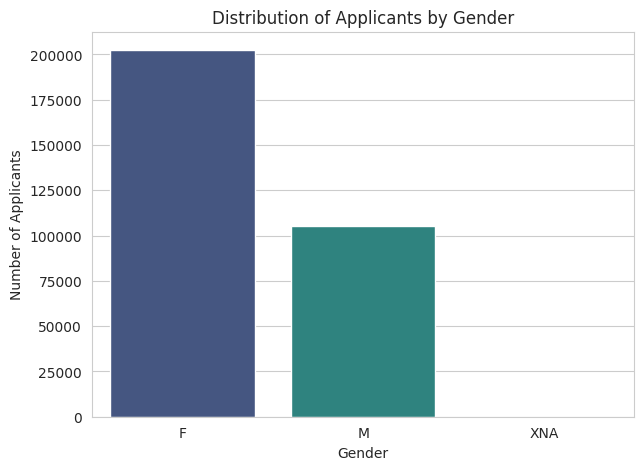

In [ ]:
print("\nNumber of male and female applicants:")
gender_counts = app_data['CODE_GENDER'].value_counts()
display(gender_counts)

plt.figure(figsize=(7, 5))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='viridis')
plt.title('Distribution of Applicants by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Applicants')
plt.show()

/tmp/ipython-input-2523949597.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(app_data['AGE_YEARS'], bins=20, kde=True, palette='coolwarm')


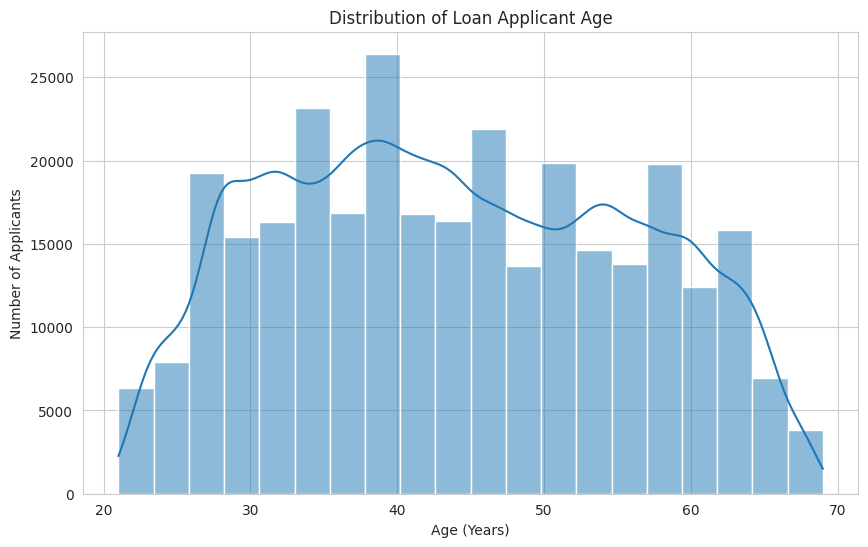

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(app_data['AGE_YEARS'], bins=20, kde=True, palette='coolwarm')
plt.title('Distribution of Loan Applicant Age')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Applicants')
plt.show()

**OUTCOMES**



**2.2.2 previous Application history data Summary**

In [ ]:

# Analyze the previous application history data
summarize_dataframe(prev_data, "PREVIOUS APPLICATION DATA (HISTORY)")


--- A. Missing Value Report (Top 20 Missing Columns) ---
| Column Name               | Data Type   |   Missing Count | Missing (%)   |
|:--------------------------|:------------|----------------:|:--------------|
| RATE_INTEREST_PRIVILEGED  | float64     |         1664263 | 99.64%        |
| RATE_INTEREST_PRIMARY     | float64     |         1664263 | 99.64%        |
| AMT_DOWN_PAYMENT          | float64     |          895844 | 53.64%        |
| RATE_DOWN_PAYMENT         | float64     |          895844 | 53.64%        |
| NAME_TYPE_SUITE           | object      |          820405 | 49.12%        |
| DAYS_LAST_DUE             | float64     |          673065 | 40.30%        |
| DAYS_FIRST_DRAWING        | float64     |          673065 | 40.30%        |
| DAYS_FIRST_DUE            | float64     |          673065 | 40.30%        |
| DAYS_TERMINATION          | float64     |          673065 | 40.30%        |
| NFLAG_INSURED_ON_APPROVAL | float64     |          673065 | 40.30%        |
| DAYS

# B. Reviewing DAYS_ Variables (Anomalies Check)


Age Distribution:
count    307511.000000
mean         43.938646
std          11.964047
min          21.000000
25%          34.000000
50%          43.000000
75%          54.000000
max          69.000000
Name: AGE_YEARS, dtype: float64

DAYS_EMPLOYED Anomalies:


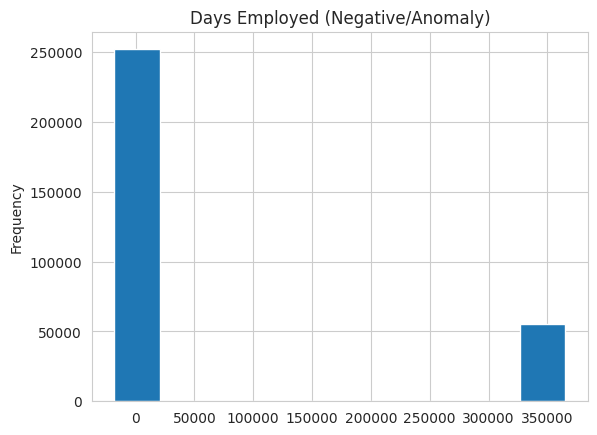

In [ ]:
# Convert DAYS_BIRTH to Age in Years (positive)
app_data['AGE_YEARS'] = (app_data['DAYS_BIRTH'] / -365).round(0)
print("\nAge Distribution:")
print(app_data['AGE_YEARS'].describe())

# Check for anomalies in DAYS_EMPLOYED
# Anomalies (e.g., extremely high negative values) often represent unemployed or 'unknown' status.
print("\nDAYS_EMPLOYED Anomalies:")
app_data['DAYS_EMPLOYED'].plot.hist(title='Days Employed (Negative/Anomaly)')
plt.show()

# You will likely find a large spike near 365,243 (or similar). The data dictionary confirms
# this is a common anomaly that must be handled.

3. Missing Value Analysis (Data Quality)


--- Missing Values in Application Data (Top 20) ---
                          Missing Count  Missing Percentage
COMMONAREA_MEDI                  214865               69.87
COMMONAREA_MODE                  214865               69.87
COMMONAREA_AVG                   214865               69.87
NONLIVINGAPARTMENTS_MODE         213514               69.43
NONLIVINGAPARTMENTS_MEDI         213514               69.43
NONLIVINGAPARTMENTS_AVG          213514               69.43
FONDKAPREMONT_MODE               210295               68.39
LIVINGAPARTMENTS_AVG             210199               68.35
LIVINGAPARTMENTS_MEDI            210199               68.35
LIVINGAPARTMENTS_MODE            210199               68.35
FLOORSMIN_MEDI                   208642               67.85
FLOORSMIN_MODE                   208642               67.85
FLOORSMIN_AVG                    208642               67.85
YEARS_BUILD_MODE                 204488               66.50
YEARS_BUILD_MEDI                 204488        

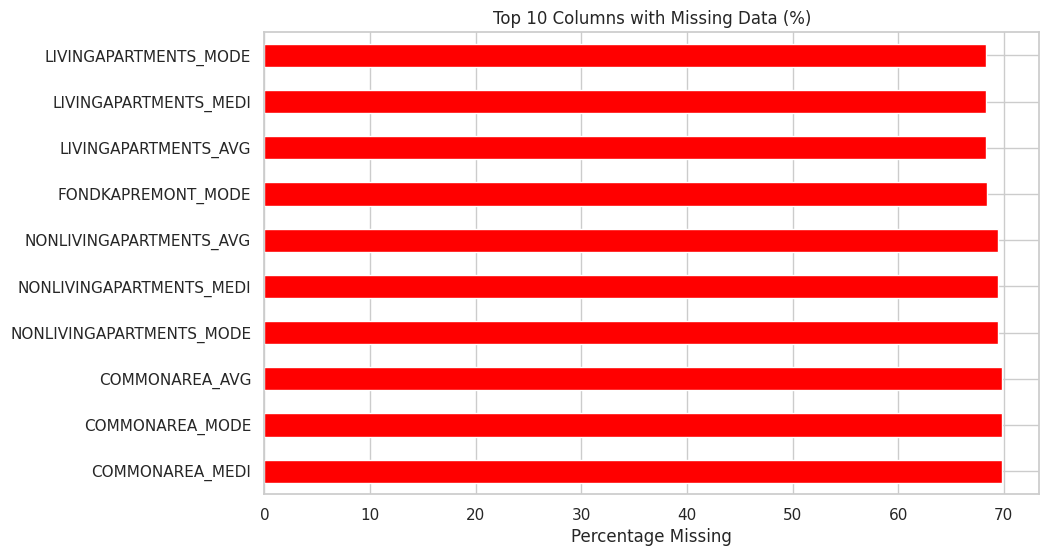

In [ ]:
def check_missing_values(df):
    """Calculates missing values and their percentage for a DataFrame."""
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    missing_percent = (missing / len(df)) * 100

    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_percent.round(2)
    })
    return missing_df

# Check missing values for the primary dataset
missing_app = check_missing_values(app_data)
print("\n--- Missing Values in Application Data (Top 20) ---")
print(missing_app.head(20))

# Example: Visualize the top 10 missing columns
missing_app.head(10)['Missing Percentage'].plot.barh(figsize=(10, 6), color='red')
plt.title('Top 10 Columns with Missing Data (%)')
plt.xlabel('Percentage Missing')
plt.show()

4. Initial Exploratory Visuals 📊

/tmp/ipython-input-1217242368.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_pivot.index, y=risk_pivot.values, palette='viridis')
/tmp/ipython-input-1217242368.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_pivot.index, y=risk_pivot.values, palette='viridis')
/tmp/ipython-input-1217242368.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_pivot.index, y=risk_pivot.values, palette='viridis')
/tmp/ipython-input-1217242368.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will

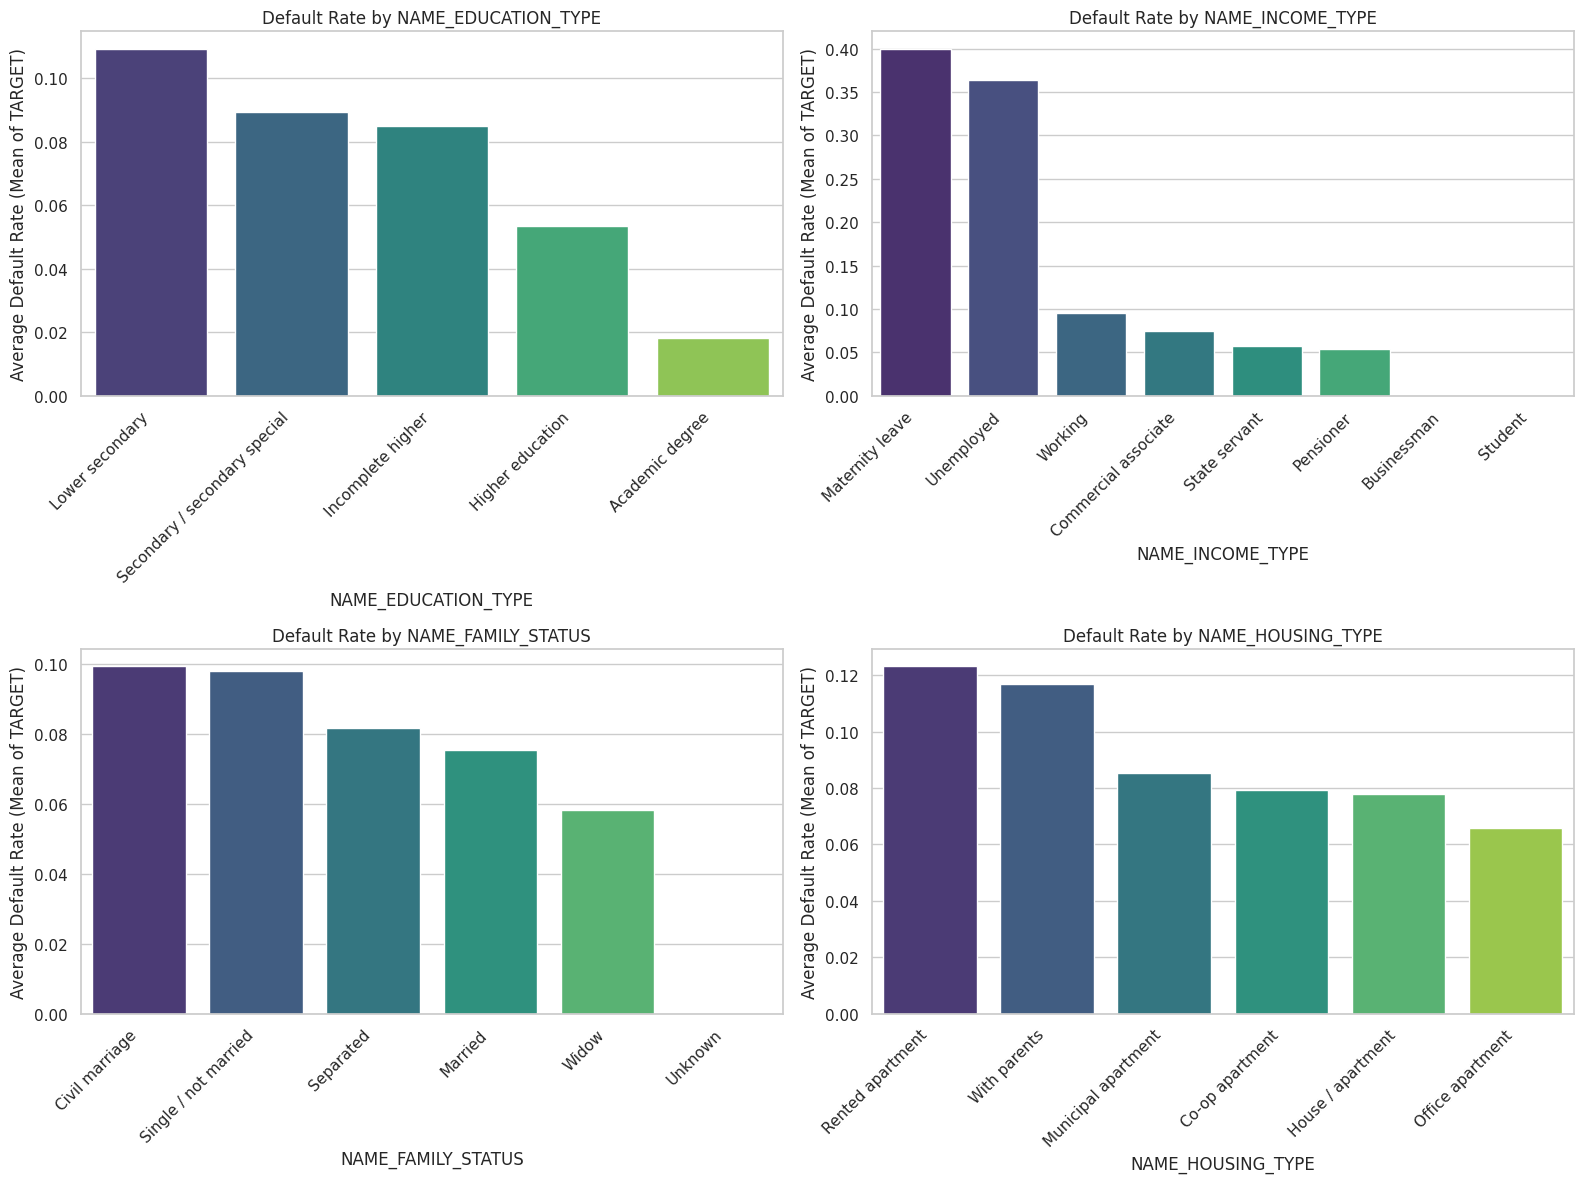

In [ ]:
# Filter out the top risk factors from the data dictionary:
# Education, Income Type, Family Status, Housing
risk_factors = ['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',]

plt.figure(figsize=(16, 12))
for i, col in enumerate(risk_factors):
    plt.subplot(2, 2, i + 1)

    # Calculate the default rate per category
    risk_pivot = app_data.groupby(col)['TARGET'].mean().sort_values(ascending=False)

    sns.barplot(x=risk_pivot.index, y=risk_pivot.values, palette='viridis')
    plt.title(f'Default Rate by {col}')
    plt.ylabel('Average Default Rate (Mean of TARGET)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()

# Insight Example: Based on this, you might write: "Clients with Lower secondary education
# show the highest average default rate."

5. Initial Risk Signals (Borrower Profiles)
Education: Clients with Lower secondary education show the highest default rate, followed by Incomplete higher. Conversely, Higher education and Academic degree holders are the lowest risk.

Insight: Lower educational attainment appears to be a strong predictor of higher default risk.

Income Type: Working individuals have the highest default rate, while State servants and Pensioners show lower risk.

Insight: While "Working" is the largest group, their default rate is disproportionately high compared to more financially secure groups like pensioners or government workers.

/tmp/ipython-input-2677058625.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


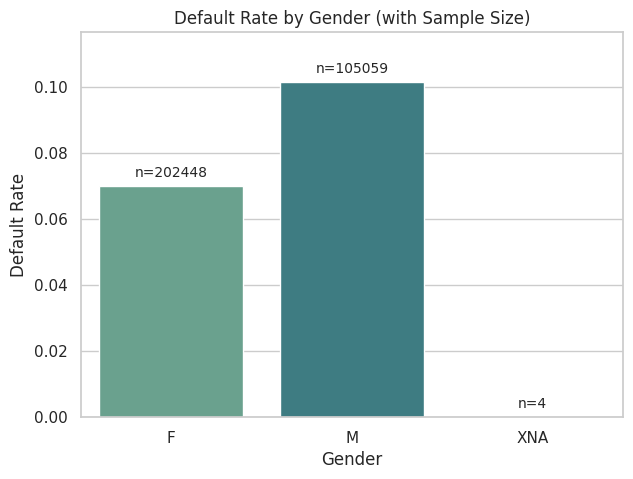


Default Rate by Gender (with sample size):


,CODE_GENDER,default_rate,sample_size
0,F,0.069993,202448
1,M,0.101419,105059
2,XNA,0.000000,4


In [ ]:
# Calculate default rate AND sample size by gender
gender_stats = (
    app_data.groupby('CODE_GENDER')
      .agg(
          default_rate=('TARGET', 'mean'),
          sample_size=('TARGET', 'count')
      )
      .reset_index()
)

# Plot
plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x='CODE_GENDER',
    y='default_rate',
    data=gender_stats,
    palette='crest'
)

# Annotate bars with sample size
for i, row in gender_stats.iterrows():
    ax.text(
        i,
        row['default_rate'] + 0.002,   # slightly above bar
        f"n={row['sample_size']}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Default Rate by Gender (with Sample Size)')
plt.xlabel('Gender')
plt.ylabel('Default Rate')
plt.ylim(0, gender_stats['default_rate'].max() * 1.15)
plt.show()

print("\nDefault Rate by Gender (with sample size):")
display(gender_stats)


Male applicants exhibit a higher observed default rate (around 10.1%) compared to female applicants (around 6.9%). Given the large sample sizes for both groups, this difference is unlikely to be driven by noise alone. However, gender may act as a proxy for other factors such as income distribution, loan size, or employment characteristics, and further multivariate analysis is required before considering any policy use.

# Outlier Detection

--- Outlier Report (K=1.5 IQR Method) ---
| FEATURE: AMT_INCOME_TOTAL
| Total Outliers: 14,035
| Percentage: 4.56%
| Lower Bound: -22,500.00
| Upper Bound: 337,500.00
| FEATURE: AMT_CREDIT
| Total Outliers: 6,562
| Percentage: 2.13%
| Lower Bound: -537,975.00
| Upper Bound: 1,616,625.00
| FEATURE: AMT_ANNUITY
| Total Outliers: 7,504
| Percentage: 2.44%
| Lower Bound: -10,584.00
| Upper Bound: 61,704.00
| FEATURE: DAYS_BIRTH
| Total Outliers: 0
| Percentage: 0.00%
| Lower Bound: -30,585.50
| Upper Bound: -1,509.50

*** Interpretation: Outliers in financial features are common but must be handled. For visualization, consider log transformations or binning to manage these extreme values. ***


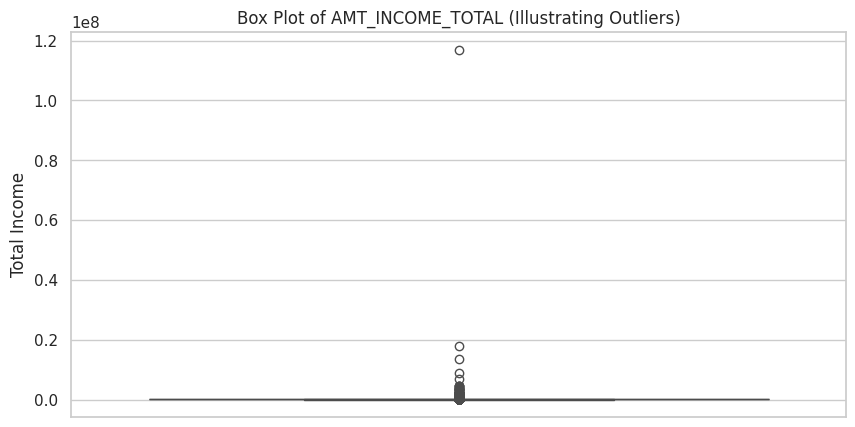

In [ ]:

# Assuming app_data is loaded and cleaned of the 365243 DAYS_EMPLOYED anomaly (if not, run app_data_cleaning.py first)

def calculate_outliers_iqr(df, column, k=1.5):
    """
    Calculates the count and percentage of outliers in a numerical column
    using the Interquartile Range (IQR) method.

    The IQR method identifies outliers as values falling below Q1 - k * IQR
    or above Q3 + k * IQR. (k=1.5 is the standard definition).
    """

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define the bounds
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    outlier_count = len(outliers)
    total_count = len(df)
    outlier_percent = (outlier_count / total_count) * 100

    return outlier_count, outlier_percent, lower_bound, upper_bound

# --- Execution: Apply to Key Financial Features ---

financial_cols = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'DAYS_BIRTH' # Time-based features often need inspection
]

print("--- Outlier Report (K=1.5 IQR Method) ---")

# Iterate through the columns and print a detailed report for each one
for col in financial_cols:
    if col in app_data.columns and app_data[col].dtype != 'object':
        count, percent, lower, upper = calculate_outliers_iqr(app_data, col)


        print(f"| FEATURE: {col}")

        print(f"| Total Outliers: {count:,}")
        print(f"| Percentage: {percent:.2f}%")
        print(f"| Lower Bound: {lower:,.2f}")
        print(f"| Upper Bound: {upper:,.2f}")


print("\n*** Interpretation: Outliers in financial features are common but must be handled. For visualization, consider log transformations or binning to manage these extreme values. ***")

# %%
# --- Visualization Example: Box Plot to Confirm Outliers ---
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize income outliers (using a log scale for better visibility if needed)
plt.figure(figsize=(10, 5))
sns.boxplot(y=app_data['AMT_INCOME_TOTAL'])
plt.title('Box Plot of AMT_INCOME_TOTAL (Illustrating Outliers)')
plt.ylabel('Total Income')
plt.show()

In [ ]:
def calculate_outliers_iqr(df, column, k=1.5):
    """
    Quantifies the count, percentage, and bounds of outliers in a numerical column
    using the Interquartile Range (IQR) method (k=1.5).
    """
    # Remove NaN values for clean quartile calculation
    data = df[column].dropna()

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define the bounds
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    # Identify outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    outlier_count = len(outliers)
    total_count = len(df)
    outlier_percent = (outlier_count / total_count) * 100

    return outlier_count, outlier_percent, lower_bound, upper_bound

# --- Execution for AMT_INCOME_TOTAL ---
if 'AMT_INCOME_TOTAL' in app_data.columns:
    count, percent, lower, upper = calculate_outliers_iqr(app_data, 'AMT_INCOME_TOTAL')

    print("--- Outlier Report for AMT_INCOME_TOTAL (K=1.5 IQR Method) ---")
    print("================================================================")
    print(f"Total Outliers: {count:,}")
    print(f"Percentage of Applicants: {percent:.2f}%")
    print(f"Lower Bound (Below this is an outlier): {lower:,.2f}")
    print(f"Upper Bound (Above this is an outlier): {upper:,.2f}")
    print("================================================================")
    print("\nInterpretation:")
    print(f"The {percent:.2f}% of clients with income above {upper:,.2f} are classified as high-income outliers.")
    print("This confirms the extreme skewness shown by the flat box plot.")
else:
    print("Error: AMT_INCOME_TOTAL column not found in app_data.")

--- Outlier Report for AMT_INCOME_TOTAL (K=1.5 IQR Method) ---
Total Outliers: 14,035
Percentage of Applicants: 4.56%
Lower Bound (Below this is an outlier): -22,500.00
Upper Bound (Above this is an outlier): 337,500.00

Interpretation:
The 4.56% of clients with income above 337,500.00 are classified as high-income outliers.
This confirms the extreme skewness shown by the flat box plot.


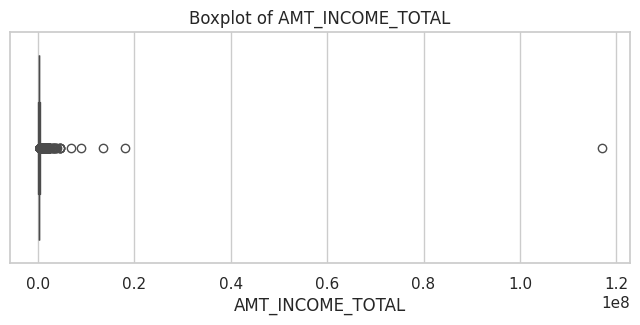

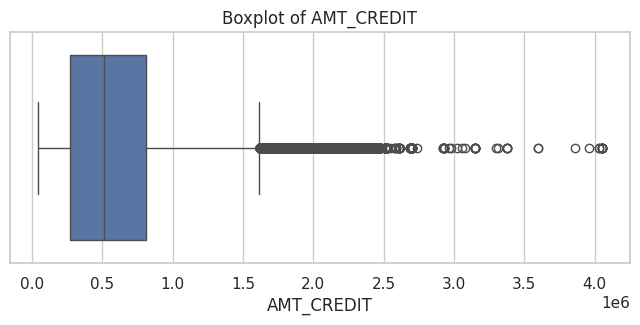

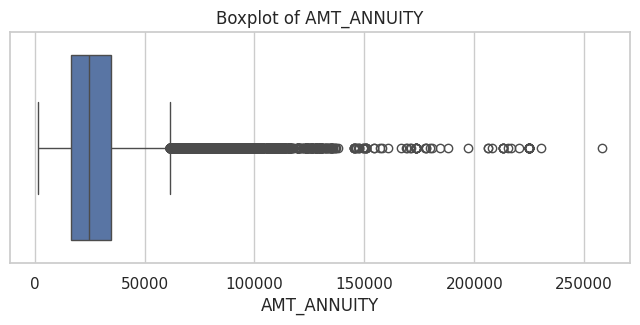

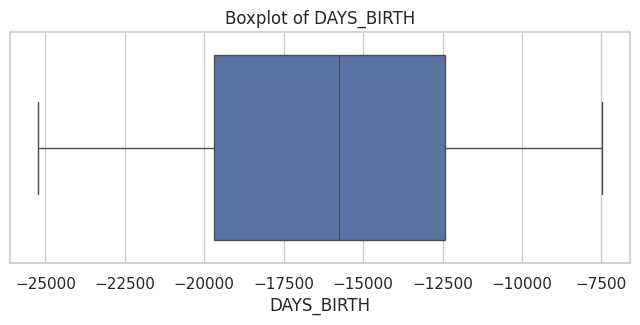

In [ ]:
num_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH']
for col in num_cols:
    plt.figure(figsize=(8,3))
    sns.boxplot(x=app_data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


/tmp/ipython-input-1132372526.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_default = app_data.groupby('AGE_GROUP')['TARGET'].mean().reset_index()
/tmp/ipython-input-1132372526.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AGE_GROUP', y='TARGET', data=age_default_prop, palette='viridis')


<Figure size 1000x500 with 0 Axes>

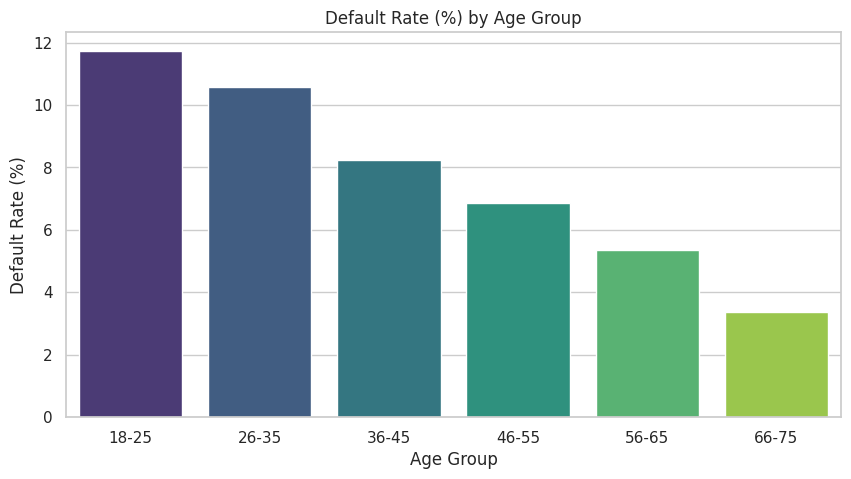

In [ ]:
# Plot Default Rate by Age Group
app_data['AGE_YEARS'] = (-app_data['DAYS_BIRTH'] / 365).astype(int)
bins_age = [18, 25, 35, 45, 55, 65, 75]
labels_age = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75']

app_data['AGE_GROUP'] = pd.cut(app_data['AGE_YEARS'], bins=bins_age, labels=labels_age, right=True)
plt.figure(figsize=(10,5))
age_default = app_data.groupby('AGE_GROUP')['TARGET'].mean().reset_index()

age_default_prop = age_default.copy()
age_default_prop['TARGET'] = age_default_prop['TARGET'] * 100

plt.figure(figsize=(10,5))
sns.barplot(x='AGE_GROUP', y='TARGET', data=age_default_prop, palette='viridis')
plt.title("Default Rate (%) by Age Group")
plt.ylabel("Default Rate (%)")
plt.xlabel("Age Group")
plt.show()


/tmp/ipython-input-1090286836.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  app_data.groupby('AGE_GROUP')['TARGET']


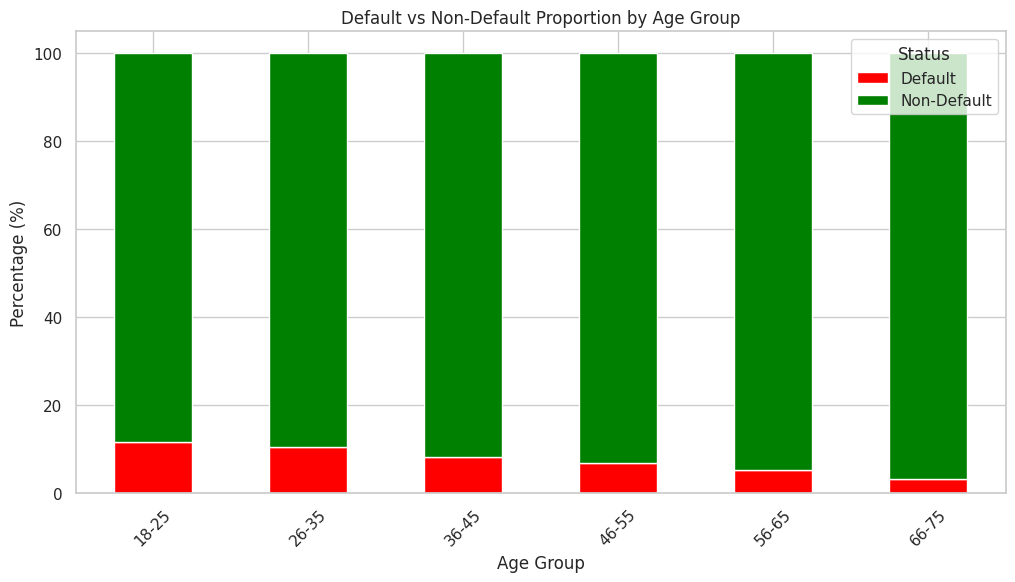

In [ ]:
# Create a table of proportions
age_prop = (
    app_data.groupby('AGE_GROUP')['TARGET']
    .value_counts(normalize=True)
    .rename('proportion')
    .mul(100)  # convert to %
    .reset_index()
)

# Rename target labels
age_prop['TARGET'] = age_prop['TARGET'].replace({0: 'Non-Default', 1: 'Default'})

# Pivot for stacked bars
pivot_age = age_prop.pivot(index='AGE_GROUP', columns='TARGET', values='proportion')

custom_colors = {
    'Non-Default': 'green',
    'Default': 'red'
}

# Plot as stacked bar chart with custom colors
pivot_age.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    color=[custom_colors[col] for col in pivot_age.columns]
)

plt.title("Default vs Non-Default Proportion by Age Group")
plt.ylabel("Percentage (%)")
plt.xlabel("Age Group")
plt.xticks(rotation=45)
plt.legend(title="Status")
plt.show()


/tmp/ipython-input-78594498.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emp_default_rate = app_data.groupby('EMPLOY_BIN')['TARGET'].mean().reset_index()
/tmp/ipython-input-78594498.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='EMPLOY_BIN', y='TARGET', data=emp_default_rate, palette='viridis')


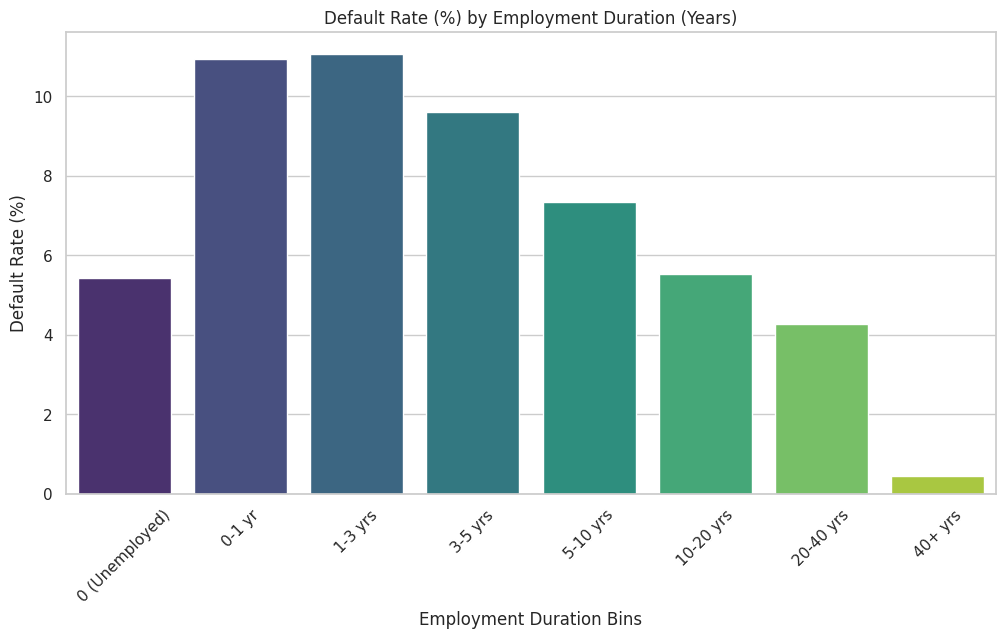

In [ ]:
# 1. Fix anomaly in DAYS_EMPLOYED
# Replace the anomaly value 365243 with 0 (representing unemployed / no stable work)
app_data['DAYS_EMPLOYED_CLEAN'] = app_data['DAYS_EMPLOYED'].replace(365243, 0)

#  2. Convert negative day counts into positive years
app_data['EMPLOY_YEARS'] = (-app_data['DAYS_EMPLOYED_CLEAN'] / 365).round(1)

# 3. Create Employment Duration Bins
bins_emp = [-1, 0, 1, 3, 5, 10, 20, 40, 60]
labels_emp = [
    '0 (Unemployed)',
    '0-1 yr',
    '1-3 yrs',
    '3-5 yrs',
    '5-10 yrs',
    '10-20 yrs',
    '20-40 yrs',
    '40+ yrs'
]

app_data['EMPLOY_BIN'] = pd.cut(app_data['EMPLOY_YEARS'], bins=bins_emp, labels=labels_emp)

#4. Compute proportionate default rate for each bin
emp_default_rate = app_data.groupby('EMPLOY_BIN')['TARGET'].mean().reset_index()
emp_default_rate['TARGET'] = emp_default_rate['TARGET'] * 100  # convert to %

plt.figure(figsize=(12, 6))
sns.barplot(x='EMPLOY_BIN', y='TARGET', data=emp_default_rate, palette='viridis')
plt.title("Default Rate (%) by Employment Duration (Years)")
plt.ylabel("Default Rate (%)")
plt.xlabel("Employment Duration Bins")
plt.xticks(rotation=45)
plt.show()


# Q. Are there behavioral clusters (spending patterns / anomalies) that correspond to higher default risk?

Using behavior features: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'EMPLOY_YEARS', 'AGE_YEARS', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'PREV_APP_COUNT', 'PREV_REFUSALS', 'LAST_PREV_APP_YEARS']

Cluster stats (Risk Ladder):


,CLUSTER_LABEL,COUNT,DEFAULT_RATE,DEFAULT_PERCENT,RISK_LADDER
0,1,35137,0.118991,11.899138,1
1,3,95880,0.102576,10.257614,2
2,0,70053,0.087605,8.760510,3
3,2,106441,0.043893,4.389286,4



Behavioral Personas (automatic summary):
Cluster 0 (N=70053): Higher: CNT_FAM_MEMBERS (3.45), CNT_CHILDREN (1.50), EMPLOY_YEARS (5.69); Lower: AMT_CREDIT (567704.20), AMT_INCOME_TOTAL (166844.16)
Cluster 1 (N=35137): Higher: AMT_INCOME_TOTAL (184670.05), PREV_APP_COUNT (12.52), PREV_REFUSALS (4.21); Lower: AMT_CREDIT (554535.18), AMT_ANNUITY (26580.15)
Cluster 2 (N=106441): Higher: AMT_CREDIT (847456.11), AMT_INCOME_TOTAL (190982.76), AMT_ANNUITY (34944.06); Lower: PREV_APP_COUNT (3.88), PREV_REFUSALS (0.33)
Cluster 3 (N=95880): Higher: EXT_SOURCE_3 (0.49), EXT_SOURCE_1 (0.46), EXT_SOURCE_2 (0.45); Lower: AMT_CREDIT (362420.98), AMT_INCOME_TOTAL (139780.30)


/tmp/ipython-input-444691385.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_stats, x='CLUSTER_LABEL', y='DEFAULT_PERCENT', order=order, palette='rocket')


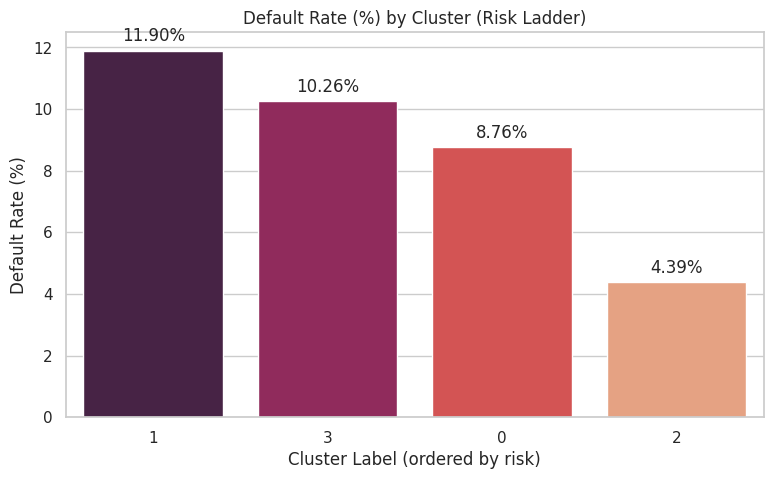

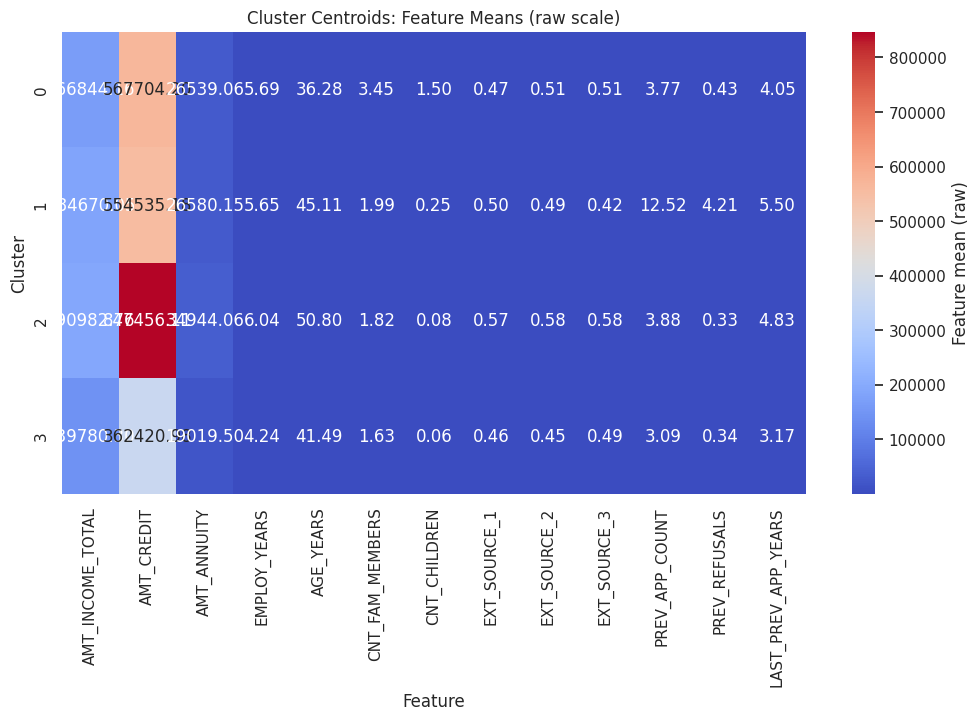

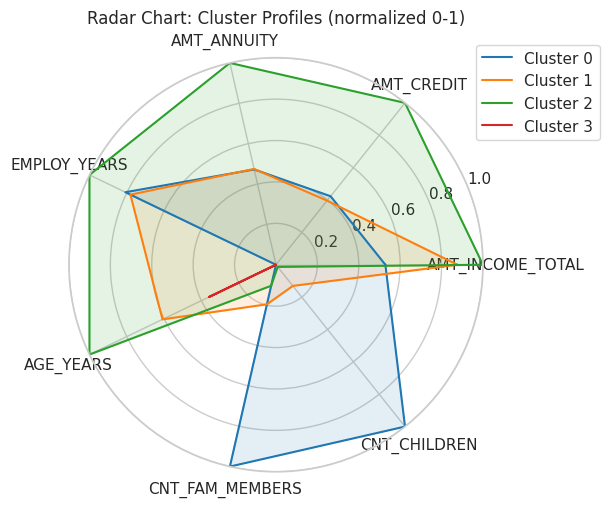

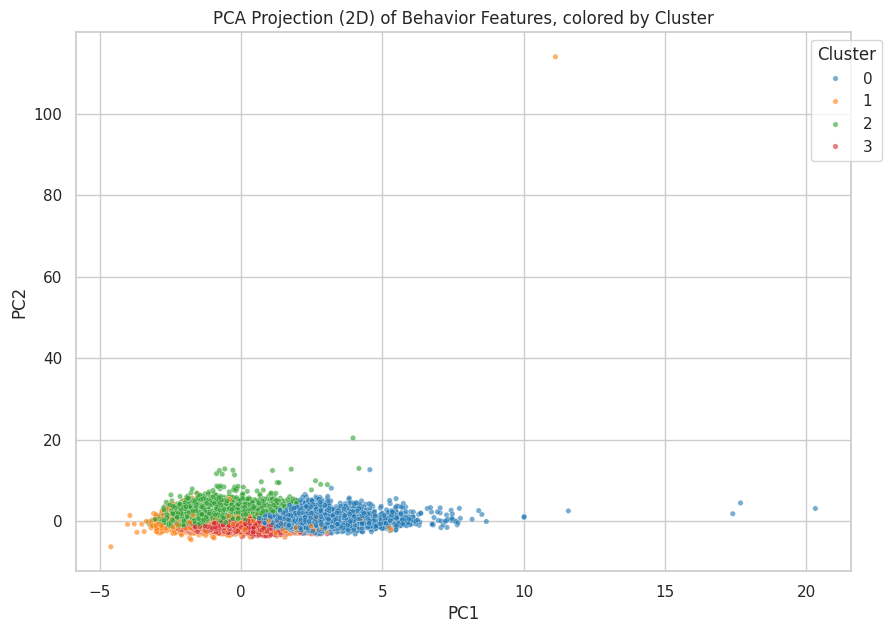


Top features that differ between high-risk and low-risk clusters:


,0
AMT_CREDIT,322475.142743
AMT_INCOME_TOTAL,29582.671795
AMT_ANNUITY,10560.826860
AGE_YEARS,2.572459
PREV_APP_COUNT,1.777915
EMPLOY_YEARS,1.284740
PREV_REFUSALS,1.007296
CNT_FAM_MEMBERS,0.739672
LAST_PREV_APP_YEARS,0.721746
CNT_CHILDREN,0.531340



Cluster Comparison Table (top rows):


,CLUSTER_LABEL,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,EMPLOY_YEARS,AGE_YEARS,CNT_FAM_MEMBERS,CNT_CHILDREN,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,PREV_APP_COUNT,PREV_REFUSALS,LAST_PREV_APP_YEARS,DEFAULT_PERCENT,COUNT
1,1,184670.052281,554535.175584,26580.150013,5.645573,45.111250,1.988701,0.249651,0.500431,0.486702,0.418280,12.523778,4.212596,5.503503,11.899138,35137
3,3,139780.303489,362420.975782,19019.504146,4.241872,41.491406,1.632645,0.061681,0.462692,0.453354,0.487430,3.086786,0.336640,3.173272,10.257614,95880
0,0,166844.156442,567704.202625,26539.060104,5.694321,36.279032,3.448989,1.498094,0.470754,0.507061,0.506972,3.774200,0.431031,4.050904,8.760510,70053
2,2,190982.761757,847456.112461,34944.059512,6.040449,50.797080,1.822052,0.080946,0.565166,0.583662,0.579054,3.882883,0.327881,4.828654,4.389286,106441



=== Short summary for report ===
Cluster 1.0: N=35137.0, Default rate ≈ 11.90%
Cluster 3.0: N=95880.0, Default rate ≈ 10.26%
Cluster 0.0: N=70053.0, Default rate ≈ 8.76%
Cluster 2.0: N=106441.0, Default rate ≈ 4.39%

Personas (short):
- Cluster 0 (N=70053): Higher: CNT_FAM_MEMBERS (3.45), CNT_CHILDREN (1.50), EMPLOY_YEARS (5.69); Lower: AMT_CREDIT (567704.20), AMT_INCOME_TOTAL (166844.16)
- Cluster 1 (N=35137): Higher: AMT_INCOME_TOTAL (184670.05), PREV_APP_COUNT (12.52), PREV_REFUSALS (4.21); Lower: AMT_CREDIT (554535.18), AMT_ANNUITY (26580.15)
- Cluster 2 (N=106441): Higher: AMT_CREDIT (847456.11), AMT_INCOME_TOTAL (190982.76), AMT_ANNUITY (34944.06); Lower: PREV_APP_COUNT (3.88), PREV_REFUSALS (0.33)
- Cluster 3 (N=95880): Higher: EXT_SOURCE_3 (0.49), EXT_SOURCE_1 (0.46), EXT_SOURCE_2 (0.45); Lower: AMT_CREDIT (362420.98), AMT_INCOME_TOTAL (139780.30)


In [ ]:
# -----------------------------
# FULL CLUSTERING REPORT
# -----------------------------


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.inspection import permutation_importance
from matplotlib.patches import Patch

sns.set(style='whitegrid', font_scale=1)



# 1. Copy & Prep data (work on copies so original frames are preserved)
app = app_data.copy()
prev = prev_data.copy()

# ---------- Feature engineering ----------
# 2. Fix DAYS_EMPLOYED anomaly (365243 -> 0 meaning unknown/unemployed)
app['DAYS_EMPLOYED_CLEAN'] = app['DAYS_EMPLOYED'].replace(365243, 0)

# 3. Derived features: Age, Employment years
app['AGE_YEARS'] = (-app['DAYS_BIRTH'] / 365).round(0).astype(int)
app['EMPLOY_YEARS'] = (-app['DAYS_EMPLOYED_CLEAN'] / 365).round(1)

# 4. Previous-application aggregates (count, refusals, recency)
# Safe replacements for anomaly in prev
prev = prev.copy()
prev['DAYS_DECISION'] = prev['DAYS_DECISION'].replace(365243, np.nan)

# Count of previous apps per customer
prev_count = prev.groupby('SK_ID_CURR').size().rename('PREV_APP_COUNT').reset_index()

# Number of previous refusals
prev_ref = prev[prev['NAME_CONTRACT_STATUS'] == 'Refused'].groupby('SK_ID_CURR').size().rename('PREV_REFUSALS').reset_index()

# Recency: days since last previous decision (min = most recent negative days)
prev_last = prev.groupby('SK_ID_CURR')['DAYS_DECISION'].min().rename('LAST_PREV_APP_DAYS').reset_index()

# Merge aggregates into application data
app = app.merge(prev_count, on='SK_ID_CURR', how='left')
app = app.merge(prev_ref, on='SK_ID_CURR', how='left')
app = app.merge(prev_last, on='SK_ID_CURR', how='left')

# Fill NaNs for aggregated counts with zeros
app['PREV_APP_COUNT'] = app['PREV_APP_COUNT'].fillna(0).astype(int)
app['PREV_REFUSALS'] = app['PREV_REFUSALS'].fillna(0).astype(int)

# Convert recency to years (positive). If NaN (no previous), keep NaN for now.
app['LAST_PREV_APP_YEARS'] = (-app['LAST_PREV_APP_DAYS'] / 365).round(1)

# 5. Define behavior + credit-bureau features to use for clustering
candidate_features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'EMPLOY_YEARS', 'AGE_YEARS',
    'CNT_FAM_MEMBERS', 'CNT_CHILDREN',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'PREV_APP_COUNT', 'PREV_REFUSALS', 'LAST_PREV_APP_YEARS'
]

# Keep only those that exist in the dataset
behavior_cols = [c for c in candidate_features if c in app.columns]
print("Using behavior features:", behavior_cols)

# 6. Prepare matrix: median impute then scale
X = app[behavior_cols].copy()

# Use median for numeric imputation (robust to outliers)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Scale
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns, index=X_imputed.index)



# -----------------------------
# 7. Clustering: choose final model (we already discovered MiniBatchKMeans k=4 works well)
# If you want to re-search: uncomment silhouette search code; here we directly fit k=4
# -----------------------------
best_k = 4  # chosen from previous silhouette search
kmeans = MiniBatchKMeans(n_clusters=best_k, batch_size=2048, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

app['CLUSTER_LABEL'] = labels

# -----------------------------
# 8. Cluster statistics: size & default rate
# -----------------------------
cluster_stats = (
    app.groupby('CLUSTER_LABEL')
       .agg(COUNT=('SK_ID_CURR','count'),
            DEFAULT_RATE=('TARGET','mean'))
       .reset_index()
)
cluster_stats['DEFAULT_PERCENT'] = cluster_stats['DEFAULT_RATE'] * 100
# Order clusters by DEFAULT_RATE descending → Risk Ladder (1 = highest risk)
cluster_stats = cluster_stats.sort_values('DEFAULT_RATE', ascending=False).reset_index(drop=True)
cluster_stats['RISK_LADDER'] = range(1, len(cluster_stats)+1)
print("\nCluster stats (Risk Ladder):")
display(cluster_stats)

# -----------------------------
# 9. Centroids & Personas
# -----------------------------
centroids = X_imputed.groupby(app['CLUSTER_LABEL']).mean()
centroids['COUNT'] = app.groupby('CLUSTER_LABEL').size()

# Overall mean for comparison
overall_mean = X_imputed.mean()

# Build persona text automatically
personas = []
for cid, row in centroids.iterrows():
    diffs = (row[behavior_cols] - overall_mean[behavior_cols])
    # top three features that are higher than average
    top_up = diffs.sort_values(ascending=False).head(3)
    top_down = diffs.sort_values(ascending=True).head(2)
    persona_text = f"Cluster {int(cid)} (N={int(row['COUNT'])}): "
    persona_text += "Higher: " + ", ".join([f"{i} ({row[i]:.2f})" for i in top_up.index]) + "; "
    persona_text += "Lower: " + ", ".join([f"{i} ({row[i]:.2f})" for i in top_down.index])
    personas.append({'cluster': int(cid), 'text': persona_text, 'count': int(row['COUNT'])})

print("\nBehavioral Personas (automatic summary):")
for p in personas:
    print(p['text'])

# -----------------------------
# 10. Visualization 1: Default Rate (%) by Cluster (Risk Ladder order)
# -----------------------------
# Re-order clusters to show Risk Ladder (highest default first)
order = cluster_stats['CLUSTER_LABEL'].tolist()

plt.figure(figsize=(9,5))
sns.barplot(data=cluster_stats, x='CLUSTER_LABEL', y='DEFAULT_PERCENT', order=order, palette='rocket')
plt.title("Default Rate (%) by Cluster (Risk Ladder)")
plt.xlabel("Cluster Label (ordered by risk)")
plt.ylabel("Default Rate (%)")
for i,row in cluster_stats.iterrows():
    plt.text(i, row['DEFAULT_PERCENT'] + 0.3, f"{row['DEFAULT_PERCENT']:.2f}%", ha='center')
plt.show()

# -----------------------------
# 11. Visualization 2: Cluster centroids heatmap (raw scale for interpretability)
# -----------------------------
centroids_plot = centroids[behavior_cols].copy().sort_index()
plt.figure(figsize=(12, 6))
sns.heatmap(centroids_plot, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label':'Feature mean (raw)'})
plt.title("Cluster Centroids: Feature Means (raw scale)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.show()

# -----------------------------
# 12. Visualization 3: Radar charts (normalized for each feature across clusters)
# -----------------------------
def radar_plot(df, features, title):
    """
    df: centroids-like DataFrame indexed by cluster label
    features: list of features to plot
    """
    # normalize cols 0-1 across clusters
    d = df[features].copy()
    d_norm = (d - d.min()) / (d.max() - d.min() + 1e-9)
    labels = list(features)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, polar=True)
    palette = sns.color_palette("tab10", n_colors=len(d_norm))
    for i, (idx, row) in enumerate(d_norm.iterrows()):
        vals = row.values.flatten().tolist()
        vals += vals[:1]
        ax.plot(angles, vals, label=f"Cluster {idx}", color=palette[i])
        ax.fill(angles, vals, alpha=0.12, color=palette[i])
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(title)
    ax.set_ylim(0,1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.05))
    plt.title(title, pad=25)     # moves title away from top
    fig.subplots_adjust(top=0.80)  # adds space above chart

    plt.show()

# choose up to 7 readable features for radar
radar_features = [f for f in behavior_cols if f in ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','EMPLOY_YEARS','AGE_YEARS','CNT_FAM_MEMBERS','CNT_CHILDREN','EXT_SOURCE_1']][:7]
radar_plot(centroids, radar_features, "Radar Chart: Cluster Profiles (normalized 0-1)")

# -----------------------------
# 13. Visualization 4: PCA 2D scatter (sample for speed)
# -----------------------------
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)
app['PC1'] = pcs[:,0]
app['PC2'] = pcs[:,1]

# sample for plotting to keep it responsive
sample = app.sample(frac=0.25, random_state=42)
plt.figure(figsize=(10,7))
sns.scatterplot(data=sample, x='PC1', y='PC2', hue='CLUSTER_LABEL', palette='tab10', alpha=0.6, s=15)
plt.title("PCA Projection (2D) of Behavior Features, colored by Cluster")
plt.legend(title='Cluster', bbox_to_anchor=(1.05,1))
plt.show()



# -----------------------------
# 14. Cluster-aware differences: features that distinguish high-risk vs low-risk clusters
# -----------------------------
# Identify high-risk & low-risk clusters (based on cluster_stats ordered by default)
ordered_clusters = cluster_stats['CLUSTER_LABEL'].tolist()
high_risk_clusters = ordered_clusters[:2] if len(ordered_clusters)>=2 else ordered_clusters[:1]
low_risk_clusters = ordered_clusters[-2:] if len(ordered_clusters)>=2 else ordered_clusters[-1:]

high_mean = X_imputed[app['CLUSTER_LABEL'].isin(high_risk_clusters)].mean()
low_mean = X_imputed[app['CLUSTER_LABEL'].isin(low_risk_clusters)].mean()
diff = (high_mean - low_mean).abs().sort_values(ascending=False)

print("\nTop features that differ between high-risk and low-risk clusters:")
display(diff.head(10))

# Cluster comparison table with default rate and centroid features
cluster_compare = centroids[behavior_cols].copy().reset_index()
cluster_compare = cluster_compare.merge(cluster_stats[['CLUSTER_LABEL','DEFAULT_PERCENT','COUNT']], left_on='CLUSTER_LABEL', right_on='CLUSTER_LABEL')
cluster_compare = cluster_compare.sort_values('DEFAULT_PERCENT', ascending=False)
print("\nCluster Comparison Table (top rows):")
display(cluster_compare.head())


# Print a brief recommended text summary :
print("\n=== Short summary for report ===")
for i,row in cluster_stats.iterrows():
    cid = row['CLUSTER_LABEL']; pct = row['DEFAULT_PERCENT']; n = row['COUNT']
    print(f"Cluster {cid}: N={n}, Default rate ≈ {pct:.2f}%")
print("\nPersonas (short):")
for p in personas:
    print(f"- {p['text']}")


# **Clustering Results: Simple Interpretation**

## **What the Clustering Shows**

Using customer income, credit amounts, family size, employment stability, and previous credit behavior, we found **4 natural groups of borrowers**.
Each group has a **different likelihood of defaulting**.

---

## **Cluster 1 — Highest Risk (~12% Default)**

**Profile:**

* Higher income than average
* **Many previous loan applications**
* **Many refusals**
* Medium loan sizes

**Meaning:**
Borrowers with “aggressive” credit-seeking behavior.
➡️ *Most likely to default.*

---

## **Cluster 3 — Second-Highest Risk (~10% Default)**

**Profile:**

* Low income
* Small loan amounts
* Few refusals
* Good external credit scores

**Meaning:**
Financially weaker borrowers who struggle due to low income.
➡️ *Moderate-to-high risk.*

---

## **Cluster 0 — Moderate Risk (~9% Default)**

**Profile:**

* **Large families and more children**
* Medium income
* Medium credit score

**Meaning:**
Borrowers under higher household financial pressure.
➡️ *Moderate risk.*

---

## **Cluster 2 — Lowest Risk (~4% Default)**

**Profile:**

* **Highest income**
* **Largest approved credit amounts**
* Stable jobs
* Very few refusals
* More mature borrowers

**Meaning:**
Prime, stable borrowers.
➡️ *Least likely to default.*

---

# **Key Insights**

* **More refusals + more past applications → higher default risk**
* **Lower income / bigger families → higher risk**
* **Higher credit scores → lower risk**
* **Higher income and stable employment → safest borrowers**

---

# **Business Impact**

* Approve Cluster 2 borrowers with confidence
* Apply stricter checks for Clusters 1 and 3
* Support Cluster 0 with customized repayment plans
* Use cluster personas to guide credit policy and risk segmentation

---